## [Dacon] 블럭 장난감 제조 공정 최적화 경진대회
## _____ (팀명)
## 2020년 월 일 (제출날짜)

1. 본 코드는 대회 참가를 돕고자 단순 예시를 작성한 것으로 참고용으로 사용바랍니다.
2. 본 코드는 자유롭게 수정하여 사용 할 수 있습니다.
3. 추가 모듈 보러가기: https://bit.ly/36MNs76

## 1. 라이브러리 및 데이터
## Library & Data

In [65]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
from copy import deepcopy
from module.genome import Genome, genome_score
warnings.filterwarnings(action='ignore')
np.random.seed(777)

In [9]:
!python --version
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))

Python 3.7.4
Pandas : 0.25.1
Numpy : 1.16.5


## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

In [4]:
# 입력하세요.

## 3. 탐색적 자료분석
## Exploratory Data Analysis

In [4]:
# 입력하세요.

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [66]:
CPU_CORE = multiprocessing.cpu_count() # 멀티프로세싱 CPU 사용 수
N_POPULATION = 50                      # 세대당 생성수
N_BEST = 5                             # 베스트 수
N_CHILDREN = 5                         # 자손 유전자 수
PROB_MUTATION = 0.5                    # 돌연변이
REVERSE = False                        # 배열 순서 (False: ascending order, True: descending order)

score_ini = 1e8                        # 초기 점수
input_length = 125                     # 입력 데이터 길이
output_length_1 = 5                    # Event (CHECK_1~4, PROCESS)
output_length_2 = 14                  # MOL(0~5.5, step:0.5)
h1 = 50                                # 히든레이어1 노드 수
h2 = 50                               # 히든레이어2 노드 수
h3 = 50                               # 히든레이어3 노드 수
EPOCHS = 15                            # 반복 횟수

#best_genomes 초기화
best_genomes=[]
# 고쳐보자
genomes = []
for _ in range(N_POPULATION):
    genome = Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3)
    genomes.append(genome)
try:
    for i in range(N_BEST):
        genomes[i] = best_genomes[i]
except:
    # best_genome 초기화하고 채우기
    # 이거 한 번 해둔 상태면 이 cell 다시 돌려도 best_genomes 안변한다ㅠ 초기화해야된다
    best_genomes = []
    for _ in range(5):
        genome = Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3)
        best_genomes.append(genome)
for _ in best_genomes:
    print(_)

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation
1. PRT는 고정값 사용
2. Event A, Event B (MOL_A, MOL_B) 를 같은 값으로 제한
3. Event는 CHECK와 PROCESS 만 사용함
4. 목적 함수로 수요 부족분만 고려함
5. Event와 MOL에 대해 인공신경망 모델을 만들어 유전 알고리즘으로 학습

In [ ]:
n_gen = 1
score_history = []
high_score_history = []
mean_score_history = []
while n_gen <= EPOCHS:    
    genomes = np.array(genomes)    
    while len(genomes)%CPU_CORE != 0:
        genomes = np.append(genomes, Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3))
    genomes = genomes.reshape((len(genomes)//CPU_CORE, CPU_CORE))
    
    for idx, _genomes in enumerate(genomes):
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes=CPU_CORE)
            genomes[idx] = pool.map(genome_score, _genomes)
            pool.close()
            pool.join()    
    genomes = list(genomes.reshape(genomes.shape[0]*genomes.shape[1]))    
    
     # score에 따라 정렬
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    # 평균 점수
    s = 0 
    for i in range(N_BEST):
        s += genomes[i].score
    s /= N_BEST
    
    # Best Score
    bs = genomes[0].score 
    
    # Best Model 추가
    if best_genomes is not None:
        genomes.extend(best_genomes)
        
    # score에 따라 정렬
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    score_history.append([n_gen, genomes[0].score])
    high_score_history.append([n_gen, bs])
    mean_score_history.append([n_gen, s])
    
    # 결과 출력
    print('EPOCH #%s\tHistory Best Score: %s\tBest Score: %s\tMean Score: %s' % (n_gen, genomes[0].score, bs, s))    
    
    # 모델 업데이트
    best_genomes = deepcopy(genomes[:N_BEST]) #5개
    
    # CHILDREN 생성 (LINE A)
    for i in range(N_CHILDREN):
        new_genome = deepcopy(best_genomes[0])
        a_genome = np.random.choice(best_genomes)
        b_genome = np.random.choice(best_genomes)
        
        for j in range(input_length):
            cut = np.random.randint(new_genome.w1_1.shape[1])
            new_genome.w1_1[j, :cut] = a_genome.w1_1[j, :cut]
            new_genome.w1_1[j, cut:] = b_genome.w1_1[j, cut:]
        
        for j in range(h1):
            cut = np.random.randint(new_genome.w2_1.shape[1])
            new_genome.w2_1[j, :cut] = a_genome.w2_1[j, :cut]
            new_genome.w2_1[j, cut:] = b_genome.w2_1[j, cut:]
        
        for j in range(h2):
            cut = np.random.randint(new_genome.w3_1.shape[1])
            new_genome.w3_1[j, :cut] = a_genome.w3_1[j, :cut]
            new_genome.w3_1[j, cut:] = b_genome.w3_1[j, cut:]
        
        for j in range(h3):
            cut = np.random.randint(new_genome.w4_1.shape[1])
            new_genome.w4_1[j, :cut] = a_genome.w4_1[j, :cut]
            new_genome.w4_1[j, cut:] = b_genome.w4_1[j, cut:]
            
        for j in range(input_length):
            cut = np.random.randint(new_genome.w5_1.shape[1])
            new_genome.w5_1[j, :cut] = a_genome.w5_1[j, :cut]
            new_genome.w5_1[j, cut:] = b_genome.w5_1[j, cut:]
        
        for j in range(h1):
            cut = np.random.randint(new_genome.w6_1.shape[1])
            new_genome.w6_1[j, :cut] = a_genome.w6_1[j, :cut]
            new_genome.w6_1[j, cut:] = b_genome.w6_1[j, cut:]
        
        for j in range(h2):
            cut = np.random.randint(new_genome.w7_1.shape[1])
            new_genome.w7_1[j, :cut] = a_genome.w7_1[j, :cut]
            new_genome.w7_1[j, cut:] = b_genome.w7_1[j, cut:]
        
        for j in range(h3):
            cut = np.random.randint(new_genome.w8_1.shape[1])
            new_genome.w8_1[j, :cut] = a_genome.w8_1[j, :cut]
            new_genome.w8_1[j, cut:] = b_genome.w8_1[j, cut:]
            
            # CHILDREN 생성
        for i in range(N_CHILDREN):
            new_genome = deepcopy(best_genomes[0])
            a_genome = np.random.choice(best_genomes)
            b_genome = np.random.choice(best_genomes)
        
        for j in range(input_length):
            cut = np.random.randint(new_genome.w1_2.shape[1])
            new_genome.w1_2[j, :cut] = a_genome.w1_2[j, :cut]
            new_genome.w1_2[j, cut:] = b_genome.w1_2[j, cut:]
        
        for j in range(h1):
            cut = np.random.randint(new_genome.w2_2.shape[1])
            new_genome.w2_2[j, :cut] = a_genome.w2_2[j, :cut]
            new_genome.w2_2[j, cut:] = b_genome.w2_2[j, cut:]
        
        for j in range(h2):
            cut = np.random.randint(new_genome.w3_2.shape[1])
            new_genome.w3_2[j, :cut] = a_genome.w3_2[j, :cut]
            new_genome.w3_2[j, cut:] = b_genome.w3_2[j, cut:]
        
        for j in range(h3):
            cut = np.random.randint(new_genome.w4_2.shape[1])
            new_genome.w4_2[j, :cut] = a_genome.w4_2[j, :cut]
            new_genome.w4_2[j, cut:] = b_genome.w4_2[j, cut:]
            
        for j in range(input_length):
            cut = np.random.randint(new_genome.w5_2.shape[1])
            new_genome.w5_2[j, :cut] = a_genome.w5_2[j, :cut]
            new_genome.w5_2[j, cut:] = b_genome.w5_2[j, cut:]
        
        for j in range(h1):
            cut = np.random.randint(new_genome.w6_2.shape[1])
            new_genome.w6_2[j, :cut] = a_genome.w6_2[j, :cut]
            new_genome.w6_2[j, cut:] = b_genome.w6_2[j, cut:]
        
        for j in range(h2):
            cut = np.random.randint(new_genome.w7_2.shape[1])
            new_genome.w7_2[j, :cut] = a_genome.w7_2[j, :cut]
            new_genome.w7_2[j, cut:] = b_genome.w7_2[j, cut:]
        
        for j in range(h3):
            cut = np.random.randint(new_genome.w8_2.shape[1])
            new_genome.w8_2[j, :cut] = a_genome.w8_2[j, :cut]
            new_genome.w8_2[j, cut:] = b_genome.w8_2[j, cut:]
        
        best_genomes.append(new_genome) # 10개!
    
    # 모델 초기화
    genomes = []
    for i in range(int(N_POPULATION / len(best_genomes))):
        for bg in best_genomes:
            new_genome = deepcopy(bg)            
            mean = 0
            stddev = 0.2                        
            # 50% 확률로 모델 변형
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w1_1 += new_genome.w1_1 * np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w2_1 += new_genome.w2_1 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w3_1 += new_genome.w3_1 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w4_1 += new_genome.w4_1 * np.random.normal(mean, stddev, size=(h3, output_length_1)) * np.random.randint(0, 2, (h3, output_length_1))                
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w5_1 += new_genome.w5_1* np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w6_1 += new_genome.w6_1 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w7_1 += new_genome.w7_1 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w8_1 += new_genome.w8_1 * np.random.normal(mean, stddev, size=(h3, output_length_2)) * np.random.randint(0, 2, (h3, output_length_2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w1_2 += new_genome.w1_2 * np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w2_2 += new_genome.w2_2 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w3_2 += new_genome.w3_2 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w4_2 += new_genome.w4_2 * np.random.normal(mean, stddev, size=(h3, output_length_1)) * np.random.randint(0, 2, (h3, output_length_1))                
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w5_2 += new_genome.w5_2* np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w6_2 += new_genome.w6_2 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w7_2 += new_genome.w7_2 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w8_2 += new_genome.w8_2 * np.random.normal(mean, stddev, size=(h3, output_length_2)) * np.random.randint(0, 2, (h3, output_length_2))
            genomes.append(new_genome)
            
    if REVERSE:
        if bs < score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3) for _ in range(N_POPULATION//2)]
    else:
        if bs > score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3) for _ in range(N_POPULATION//2)]  
        
    n_gen += 1

## 6. 결과 및 결언
## Conclusion & Discussion

### 결과 그래프

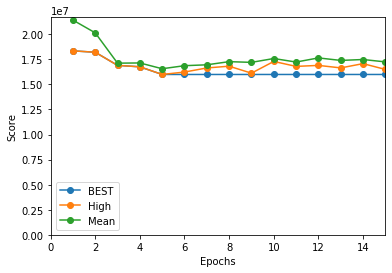

In [6]:
import matplotlib.pyplot as plt

# Score Graph
score_history = np.array(score_history)
high_score_history = np.array(high_score_history)
mean_score_history = np.array(mean_score_history)

plt.plot(score_history[:,0], score_history[:,1], '-o', label='BEST')
plt.plot(high_score_history[:,0], high_score_history[:,1], '-o', label='High')
plt.plot(mean_score_history[:,0], mean_score_history[:,1], '-o', label='Mean')
plt.legend()
plt.xlim(0, EPOCHS)
plt.ylim(bottom=0)
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.show()

### Submission 파일 만들기

In [7]:
# 재고 계산
from module.simulator import Simulator
simulator = Simulator()
order = pd.read_csv('module/order.csv')
submission = best_genomes[0].predict(order)
_, df_stock = simulator.get_score(submission) 

# PRT 개수 계산
PRTs = df_stock[['PRT_1', 'PRT_2', 'PRT_3', 'PRT_4']].values
PRTs = (PRTs[:-1] - PRTs[1:])[24*23:]
PRTs = np.ceil(PRTs * 1.1)
PAD = np.zeros((24*23+1, 4))
PRTs = np.append(PRTs, PAD, axis=0).astype(int)

# Submission 파일에 PRT 입력
submission.loc[:, 'PRT_1':'PRT_4'] = PRTs
submission.to_csv('Dacon_baseline_calculator_revised.csv', index=False)

### 점수 향상 팁
해당 코드는 단순한 모델로 다음 방법으로 점수 향상을 꾀할 수 있습니다.
1. 성형 공정 2개 라인을 따로 모델링
2. CHANGE, STOP 이벤트 활용
3. 수요 초과분 외 다양한 양상을 반영하는 목적함수
4. 유전 알고리즘 외 효율적인 학습 기법

In [2]:
import numpy as np
np.zeros([5], np.bool)

array([False, False, False, False, False])

In [42]:
x = np.array([[1,2,3],[4,5,6],[7,8,9],[0,1,2]])
np.shape(x)


(4, 3)

In [40]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

In [45]:

y = x[:2, 1:3].reshape(-1)
y

array([2, 3, 5, 6])

In [33]:
order_ini = pd.read_csv('order.csv') # 블럭장난감 일별수요

In [23]:
order_ini.head()

,time,BLK_1,BLK_2,BLK_3,BLK_4
0,2020-04-01,0,0,0,0
1,2020-04-02,0,0,0,0
2,2020-04-03,0,0,0,0
3,2020-04-04,0,0,0,0
4,2020-04-05,0,0,0,0


In [59]:
temp = order_ini

In [42]:
# for i in range(30):
#     temp[i, 1:5] = [temp[i,1]*(1/0.851), temp[i,2]*(1/0.901), temp[i,3]*(1/0.71), temp[i,4]*(1/0.7)]



pandas.core.series.Series

In [57]:
blk = np.array(temp.loc[:, "BLK_1":"BLK_4"])
blk

array([[    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0, 18018,     0,     0],
       [    0, 20437,     0,     0],
       [    0, 12059,     0,     0],
       [    0, 12059,     0,     0],
       [    0, 12059,     0,     0],
       [    0, 12059,     0,     0],
       [    0, 12059,     0,     0],
       [    0, 12059,     0,     0],
       [    0, 12059,     0,     0],
       [    0,  2954,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
 

In [58]:
for idx, x in enumerate(blk):
    if idx<30:
        x[0] = x[0]*(1/0.851) * (1/0.975)
        x[1] = x[1] * (1/0.901) * (1/0.975)
        x[2] = x[2] *(1/0.701) *(1/0.975)
        x[3] = x[3] * (1/0.7)*(1/0.975)
    elif idx <61:
        x[0] = x[0]*(1/0.851)*(1/0.975)
        x[1] = x[1] * (1/0.901)*(1/0.975)
        x[2] = x[2] *(1/0.742)*(1/0.975)
        x[3] = x[3] * (1/0.731)*(1/0.975)
    else:
        x[0] = x[0]*(1/0.851)*(1/0.975)
        x[1] = x[1] * (1/0.901)*(1/0.975)
        x[2] = x[2] *(1/0.759)*(1/0.975)
        x[3] = x[3] * (1/0.749)*(1/0.975)
blk

        
        

array([[    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0, 20510,     0,     0],
       [    0, 23264,     0,     0],
       [    0, 13727,     0,     0],
       [    0, 13727,     0,     0],
       [    0, 13727,     0,     0],
       [    0, 13727,     0,     0],
       [    0, 13727,     0,     0],
       [    0, 13727,     0,     0],
       [    0, 13727,     0,     0],
       [    0,  3362,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [    0,     0,     0,     0],
 

In [61]:
temp.loc[:, "BLK_1":"BLK_4"] = blk

In [62]:
temp

,time,BLK_1,BLK_2,BLK_3,BLK_4
0,2020-04-01,0,0,0,0
1,2020-04-02,0,0,0,0
2,2020-04-03,0,0,0,0
3,2020-04-04,0,0,0,0
4,2020-04-05,0,0,0,0
...,...,...,...,...,...
86,2020-06-26,51220,0,85011,85025
87,2020-06-27,51220,0,56675,85025
88,2020-06-28,51220,0,56675,85025
89,2020-06-29,51220,0,56675,42512


In [64]:
temp.to_csv('order_extended.csv', index=False)